# Probabilistic Machine Learning
#### Machine Learning in Science, University of Tübingen, Summer Semester 2022
## Exercise 08

Author: Janne Lappalainen

**hand in before 24.06.2022, 12:00 p.m. (noon)**

---


## Leander Zimmermann 4165446
## Julian Zimmerlin 6009977

# 1. EXAMple

## a)
\begin{align}
    \mathbb{E}_{p(\theta | x)} \left[ L(\hat\theta,\theta)\right] 
    &= \sum_{j=1}^C L(\hat\theta,j) \cdot p(\theta=j | x) \\
    &= \sum_{j=1}^C \left(\mathbf{I}[\hat\theta \neq j] \cdot \mathbf{I}[\hat\theta \neq C+1] + r\cdot\mathbf{I}[\hat\theta = C+1] \right) \cdot p(\theta=j | x) \\
    &= \mathbf{I}[\hat\theta \neq C+1] \cdot \sum_{j=1}^C \left[\mathbf{I}[\hat\theta \neq j] \cdot p(\theta=j | x) \right] + \mathbf{I}[\hat\theta = C+1] \cdot \underbrace{\sum_{j=1}^C \left[r\cdot p(\theta=j | x)\right]}_{=r} \\
    &= \mathbf{I}[\hat\theta \neq C+1] \cdot \sum_{j=1}^C \left[\mathbf{I}[\hat\theta \neq j] \cdot p(\theta=j | x) \right] + \mathbf{I}[\hat\theta = C+1] \cdot r \\
    &= \begin{cases}\sum_{j=1}^C \left[\mathbf{I}[\hat\theta \neq j] \cdot p(\theta=j | x) \right] & \text{if } i\in\{1,\dots, C\} \\ r & \text{else} \end{cases}
\end{align}

## b)
\begin{align}
    j&\in\{1,\dots, C\} \\
    j&= \arg\min_{\hat\theta} \mathbb{E}_{p(\theta | x)} \left[ L(\hat\theta,\theta)\right] \\
    \implies& \mathbb{E}_{p(\theta | x)} \left[ L(j,\theta)\right] \leq \mathbb{E}_{p(\theta | x)} \left[ L(k,\theta)\right] \quad \forall k\neq j 
    \\ \\
    \text{for } k \in \{1,\dots, C\}:
    \\
    \implies& \sum_{i=1}^C \left[\mathbf{I}[j \neq i] \cdot p(\theta=i | x) \right] \leq \sum_{i=1}^C \left[\mathbf{I}[k \neq i] \cdot p(\theta=i | x) \right] \\
    \iff& \sum_{i=1}^C \left[p(\theta=i | x)\right] - p(\theta=j | x) \leq \sum_{i=1}^C \left[p(\theta=i | x)\right] - p(\theta=k | x) \\
    \iff& p(\theta=j | x) \geq p(\theta=k | x) 
    \\\\
    \text{for } k \not\in \{1,\dots, C\}:
    \\
    \implies& \sum_{i=1}^C \left[\mathbf{I}[j \neq i] \cdot p(\theta=i | x) \right] \leq r \\
    \iff& \underbrace{\sum_{i=1}^C \left[p(\theta=i | x) \right]}_{=1} - p(\theta=j | x) \leq r \\
    \iff& p(\theta=j | x) \geq 1-r \\\\
\end{align}  
\begin{align}
    p(\theta=j | x) &< 1-r \\
    \implies& \sum_{i=1}^C \left[\mathbf{I}[j \neq i] \cdot p(\theta=i | x) \right] > r \\
    \implies& \arg\min_{\hat\theta} \mathbb{E}_{p(\theta | x)} \left[ L(\hat\theta,\theta)\right] = C+1
\end{align}

## c) 


In the lecture you learned about making decisions based on inferred posterior distributions. In this programming exercise, you will implement a multi-arm bandit problem to learn about one algorithm for decision making.

## Outline
1. The Multi-armed bandit: Learning by doing often involves a dilemma between exploration and exploitation.
2. The upper confidence bound algorithm (UCP) is designed to find the right balance between exploration and exploitation. Use this with the multi-armed bandit you implemented.

References:
- Philipp Henning. "Probabilistic Machine Learning". Lecture 26. https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/methoden-des-maschinellen-lernens/lehre/probabilistic-machine-learning/
- Kevin P Murphy. "Machine Learning A Probabilistic Perspective". Section 5.7.3.1.
- Lai, Tze Leung, and Herbert Robbins. "Asymptotically efficient adaptive allocation rules." Advances in applied mathematics 6.1 (1985): 4-22.
https://www.sciencedirect.com/science/article/pii/0196885885900028?via%3Dihub

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.distributions import beta

np.random.seed(42)

# The Multi-armed bandit
## Learning by doing often involves a dilemma between exploration and exploitation

You like to listen to music and have this one playlist of favorite songs that you can listen to over and over? By always listening to that same playlist you might not get to knowp potential new songs that you might like even better. To find such new songs, you'd need to explore new music. 

The key dilemma here is: should you explore new options to get to know better ones or do you exploit the best ones you know to avoid the risk of getting no reward?

If you can't relate to the above example, here are some more: 
- find the best cure for your hangover 
- finding the best restaurant for you
- find the best area of research for you to work on

Many real-life decisions can involve a tension between exploration and exploitation.

We generalize this a bit, to define multi-armed bandit problem that can describe all of the above examples (named after a slot machine with multiple levers with different probabilities of return). After an initial analysis, your task will be to implement a solving algorithm that is designed to find the right balance between exploration and exploitation to solve the multi-armed bandit problem.

Imagine you have $K$ actions $a_k$,  $k\in\mathbb{N}$ in front of you with different probabilities of rewarding you. For simplicity, let's assume that the reward $x_k$ for action $a_k$ is binary 

$$ 
x_k=\begin{cases}
      1, & \text{with probability } \theta_k\\
      0, & \text{with probability } 1 - \theta_k
\end{cases}
$$

Your goal is to take those actions $a^*$ that maximize your expected reward.

<!-- $a^* = \text{arg}\max_a \int x(\theta)p(\theta|a)\text{d}\theta$
 -->
However, you don't yet know which action rewards you with which probability. How many times should you try each action (explore) before deciding to go with the one having rewarded you most (exploit)? In order to learn that, you will need to perform multiple trials $n_k\in\mathbb{N}$ on each action $k$ from which $m_k<n_k, m_k \in\mathbb{N}$ result in a reward. We can maintain and update a belief about the probability of being rewarded $p(\theta_k | n_k, m_k)$ to devise an optimal action-policy.

Remember from Lecture 3, that the posterior probability of reward from $n_k$ observations can be expressed as a Beta distribution
$$p(\theta_k | n_k, m_k, a, b) = \frac{\theta_k^{n_k + a + 1}(1 - \theta_k)^{n_k - m_k + b - 1}}{B(n_k + a, n_k - m_k + b)}=\mathcal{B}(\theta_k| a + m_k, b + n_k - m_k)$$ 
with conjugate prior
$$p(\theta_k) = \frac{\theta_k^{a-1}(1-\theta_k)^{b-1}}{B(a, b)} = \mathcal{B}(\theta_k| a, b)\,\text{.}$$

The beta-distributed posterior has mean

$\bar{\theta_k} := \mathrm{E}_{p(\theta_k | n_k, m_k, a, b)}[\theta_k]=\frac{a + m_k}{a + b + n_k}$

and variance

$\sigma_k^2:=\mathrm{V}_{p(\theta_k | n_k, m_k, a, b)}[p_k]=\frac{(a + m_k)(b + n_k-m_k)}{(a + b + n_k)^2(a + b + n_k + 1)}\text{.}$

1. Complete the implementation of `mean` and `var` in the class `BetaDistribution` below.

In [172]:
class BetaDistribution:
    """Beta distribution."""

    def __init__(self, a, b):
        self.a = a
        self.b = b

    def sample(self, size):
        """Sample size samples from the distribution."""
        return beta.rvs(self.a, self.b, size=size)

    def pdf(self, x=None):
        """Return the probability density function."""
        if x is None:
            x = np.linspace(0, 1, 100)
        return beta.pdf(x, self.a, self.b)

    def is_bernoulli(self):
        # for a, b -> 0, the BetaDistribution is
        # Bernoulli with p = 1/2
        return self.a == 0 or self.b == 0

    def mean(self):
        """Return the mean of the beta distribution.

        Note: If either a or b are 0, returns the mean of
        a bernoulli distribution with p = 1/2.
        """
        if self.is_bernoulli():
            return 1 / 2
        else:
            return self.a / (self.a + self.b)

    def var(self):
        """Return the variance of the beta distribution.

        Note: If either a or b are 0, returns the variance
        of a bernoulli distribution with p = 1/2.
        """
        if self.is_bernoulli():
            return 1 / 4
        else:
            return self.a * self.b / ((self.a+self.b)**2 * (self.a+self.b+1))

    def update(self, a, b):
        """Update parameters a and b."""
        self.a = a
        self.b = b

2. Complete the implementation of `pull` in the `MultiArmedBandit` class below.

In [173]:
class MultiArmedBandit:
    """Multi-armed bandit with binary reward.

    Args:
        K: number of arms or actions.
        probabilities: probability of reward for each arm.
        seed: seed for random number generator.
    """

    def __init__(self, K: int, probabilities: list = None, seed=None):

        # to make analysis deterministic use a random state
        self.seed = seed
        self.random_state = np.random if seed is None else np.random.RandomState(seed)

        self.K = K

        # to provide or set probilities randomly
        if probabilities is None:
            probabilities = [self.random_state.random() for i in range(self.K)]
        self.probabilities = probabilities

    def __repr__(self):
        return (
            f"{self.__class__.__name__}("
            f"K={self.K},"
            f"probabilities={self.probabilities},"
            f"seed={self.seed})"
        )

    def pull(self, k: int):
        """Returns a reward x_k with probability $\theta_k$."""
        if k >= self.K or k < 0:
            raise ValueError
        return int(self.random_state.rand() < self.probabilities[k])
        
    def pull_many_times(self, k: int, trials: int):
        """"""
        return np.array([self.pull(k) for _ in range(trials)])

3. Use your MultiArmedBandit to plot $\bar{\theta_k}$ over $n_k$ for each action $k$. Therefore, create a bandit with with $K=3$ and latent probabilities to return reward of $\theta_1 = 0.45, \theta_2 = 0.5, \theta_3 = 0.55$. Create the prior distribution for each arm (choose $a$ and $b$ as you want).

Pull each arm of the bandit $n\in[1, 2, ..., 1000]$ times. For each $n$, update the prior distributions based on $n_k, m_k$ to obtain the posterior. Record the expected probability of return for each arm to plot them.

How large would $n$ need to be in order to tell confidently that one arm is more likely to return reward?

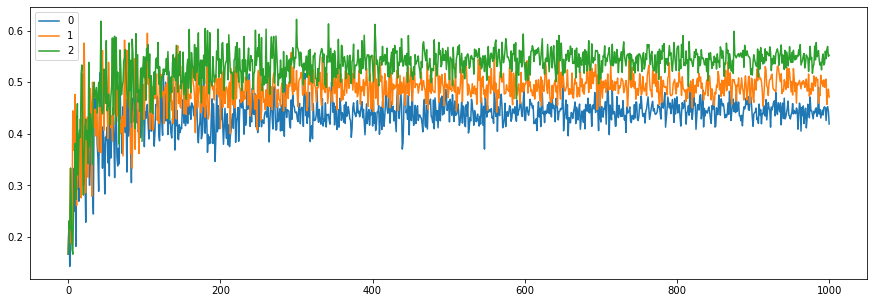

In [180]:
N = 1000
K = 3
probs = [.45,.5,.55]

ns = np.arange(N+1)
ms = np.zeros((K, N+1))
mean_probs = np.zeros((K, N+1))


mab = MultiArmedBandit(K, probabilities=probs, seed=42)

priors = []

fig, ax = plt.subplots(figsize=(15,5))

for k in range(K):
    priors.append(BetaDistribution(2, 10))
    
    for n in ns:
        m = mab.pull_many_times(k, n).sum()
        dist = BetaDistribution(priors[k].a + m, priors[k].b + n - m)
        mean_probs[k,n] = dist.mean()
        ms[k,n] = m
        

    ax.plot(ns, mean_probs[k, :], label=k)

ax.legend()

plt.show()

4. Plot the posterior distributions for each arm for a few $n$. Can you observe how it converges?

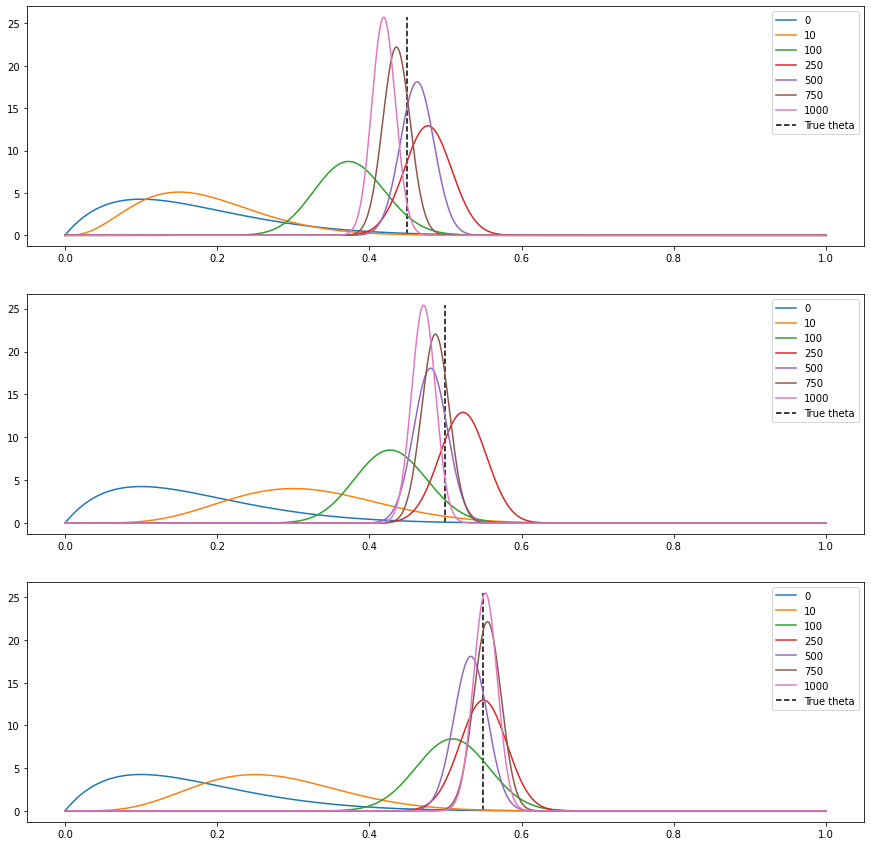

In [182]:
ns = [0, 10, 100, 250, 500, 750, 1000]
x = np.linspace(0, 1, 1000)
fig, axs = plt.subplots(3,1,figsize=(15,15))
for k in range(K):
    for n in ns:
        m = ms[k,n]
        dist = BetaDistribution(priors[k].a + m, priors[k].b + n - m)
        pdf = dist.pdf(x)
        axs[k].plot(x, pdf, label=n)
        upper_lim = pdf.max()
    axs[k].vlines(probs[k], 0, upper_lim, color='black', linestyle='--', label='True theta')
    axs[k].legend()
plt.show()

## The upper confidence bound algorithm (UCP) is designed to find the right balance between exploration and exploitation

Now, each trial comes at a cost. To pull the lever of a slot machine you need to insert coins, to listen to music you spend time, to test a drug you risk the health of your patients and so on. Therefore, it is important to devise a policy that optimally balances the exploration vs. the exploitation to get rewarded as much as possible but to also gain new knowledge at the same time within $n$ trials.

One common heuristic is to take the action that maximizes the upper confidence
$$a^* = \text{arg}\max_{a_k}\bar{\theta}_k + c \cdot \sigma_k$$

The first term is called the exploitation term and the second term is called the exploration term. The factor $c$ is to tune the tradeoff between exploitation and exploration. One common and provably near optimal choic is
$c=\sqrt{2\log{\sum_k n_k}}$. Intuitively, we would want to pick actions which are good (large $\bar{\theta_k}$) to gain reward or actions for which we are uncertain (large $\sigma_k$) to gain new knowledge.

You will implement an `Agent` that chooses the next arm to pull based on past pulls and rewards using the upper confidence bound algorithm. The pseudocode for the algorithm is:

```python
def ucb(agent, multiarmedbandit, n, c):

    # pull each arm once
    for arm in multiarmedbandit:
        agent.pull(arm)

    # compute the best next arm based on ucb and pull
    for trial in n:
        next_arm = agent.argmax(
            [
                agent.upper_confidence(arm, c)
                for arm in multiarmedbandit
            ]
        )
        agent.pull(next_arm)
```

1. Complete the methods `upper_confidence_bound`, `next_action`, and `learn` to create a functioning `Agent`. Refer to the pseudocode above to infer the dependencies between the methods.

In [383]:
class Agent:
    """An Agent to pull the arms of the bandit.

    Args:
        multiarmedbandit: a bandit instance.
        a: prior parameter a.
        b: prior parameter b.
    """

    def __init__(self, multiarmedbandit: MultiArmedBandit, a=0, b=0):

        self.bandit = multiarmedbandit

        # to keep track of the rewards over successive trials
        # we initialize a list for each arm
        self.rewards = {i: [] for i in range(self.bandit.K)}
        # to keep track of the number of pulls of each arm
        # we incrementally increase the values in this dict
        self.number_of_pulls = {i: 0 for i in range(self.bandit.K)}
        self.a = a
        self.b = b

    def __repr__(self):
        return f"{self.__class__.__name__}({self.bandit})"

    def pull(self, k):
        """
        Pull arm k of the bandit.

        Note: tracks 0 reward for arms that are not pulled and
        increases the pull counter for arm k.
        """
        # we even track zero rewards for arms that are not played
        # to be able to conveniently
        # show the cumulative reward for each arm over time
        for _k in range(self.bandit.K):
            if _k == k:
                self.rewards[k].append(self.bandit.pull(k))
            else:
                self.rewards[_k].append(0)

        self.number_of_pulls[k] += 1

    @property
    def n_pulls(self):
        """The total number of pulls the agent has performed."""
        return sum(self.number_of_pulls.values())

    def next_action(self, exploration_factor=None) -> int:
        """The next action of the agent.

        Args:
            exploration_factor: to tune exploitation vs. exploration.
                $c$ in the formalism above.
                Defaults to None, i.e. c = sqrt(2 * log(n)).
        """
        
        ucbs = [self.upper_confidence_bound(k, exploration_factor) for k in range(self.bandit.K)]
        next_arm = np.argmax(ucbs)
        self.pull(next_arm)

    def upper_confidence_bound(self, k, exploration_factor=None) -> float:
        """The upper confidence for arm k.

        Args:
            exploration_factor: to tune exploitation vs. exploration.
                $c$ in the formalism above.
                Defaults to None, i.e. c = sqrt(2 * log(n)).
        """
        if exploration_factor is None:
            # common choice to slightly increase the exploration
            # over time which grows slower than n_k in the denominator
            # to ensure that this factor does not blow up the exploration term
            # while putting emphasis on the less explored options
            exploration_factor = np.sqrt(2 * np.log(self.n_pulls))

        # create posterior and compute ucb using its methods
        n = self.number_of_pulls[k]
        m = sum(self.rewards[k])
        
        posterior = BetaDistribution(self.a + m, self.b + n - m)
        
        return posterior.mean() + exploration_factor * posterior.var()

    def learn(self, n_trials, exploration_factor=None):
        """Let the agent learn what the arm with the highest probability of reward is.

        Args:
            n_trials: number of trials that the agent is allowed to pull arms
                of the bandit.
            exploration_factor: to tune exploitation vs. exploration.
                $c$ in the formalism above.
                Defaults to None, i.e. c = sqrt(2 * log(n)).
        """
        for i in range(n_trials):
            self.next_action(exploration_factor)

    def optimal_choice_prediction(self):
        """What the agent would predict as optimal choice."""
        # to just take the mean and not the standard deviation
        # into account, pass exploration_factor=0 to next_action
        return self.next_action(exploration_factor=0)

    def regret(self):
        """The empirical regret of the agent."""
        n = len(self.rewards[0])
        return n - np.sum(list(self.rewards.values()))

    def cumulative_regret(self):
        """The cumulative empirical regret of the agent over successive trials."""
        n = len(self.rewards[0])
        return np.arange(1, n+1) - np.array(list(self.rewards.values())).sum(axis=0).cumsum()

    def expected_regret(self):
        """The expected regret."""
        # the number of trials per arm is binomial, the expected value
        # of reward for each arm k is 1 / K * theta_k * n
        n = len(self.rewards[0])
        exp_rewards = n/self.bandit.K * np.array(self.bandit.probabilities)
        return n - exp_rewards.sum()

    def expected_cumulative_regret(self):
        """The cumulative expected regret of the agent over successive trials."""
        n = len(self.rewards[0])
        ns = np.arange(1, n+1)
        return ns - 1/self.bandit.K * np.outer(self.bandit.probabilities,ns).sum(axis=0)
        

2. Initialize a multi-armed bandit with the parameters above and pass it to the agent. Give the agent $n=500$ trials to learn which the best action is and visualize the cumulative reward for each arm against the number of trials. Interpret the plot to gain a more intuitive understanding for the algorithm. (Hint: you can use `np.cumsum` to accumulate the rewards stored for each arm.)
3. Vary the exploration factor c. What can be problematic with too small or too large values of $c$?

<ipython-input-377-87de4a3894db>:75: RuntimeWarning: divide by zero encountered in log
  exploration_factor = np.sqrt(2 * np.log(self.n_pulls))
<ipython-input-377-87de4a3894db>:75: RuntimeWarning: invalid value encountered in sqrt
  exploration_factor = np.sqrt(2 * np.log(self.n_pulls))


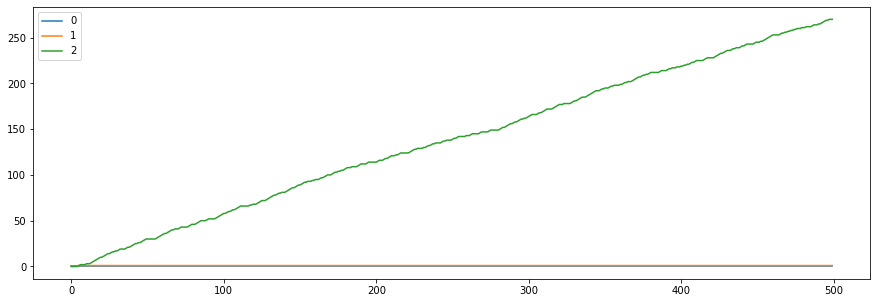

In [378]:
n_trials = 500
n_arms = 3
probabilities = [.45,.5,.55]
bandit = MultiArmedBandit(n_arms, probabilities=probabilities, seed=42)
agent = Agent(bandit)
agent.learn(n_trials)
cum_rewards = {arm: np.cumsum(rewards) for arm, rewards in agent.rewards.items()}

fig, ax = plt.subplots(figsize=(15,5))
for arm in range(n_arms):
    ax.plot(list(range(n_trials)), cum_rewards[arm], label=arm)
ax.legend()
plt.show()

4. A measure of how successful our policy was, is subtracting the reward that we got in $n$ trials from the maximal reward that we could have gotten. With binary reward $x\in[0, 1]$, the _expected regret_ is
$$
r = n - \sum_kE[m_k] = n - \frac{1}{K}\sum_k \theta_k n
$$ 
  and the _empirical regret_ is
$$
r = n - \sum_k m_k\text{.}
$$
Implement the methods `regret`, `cumulative_regret`, `expected_regret`,  `expected_cumulative_regret` for the `Agent` class. 

5. Let your agent learn again for $n=500$ trials. Compare the cumulative regret against the cumulative expected regret. Do these roughly match?

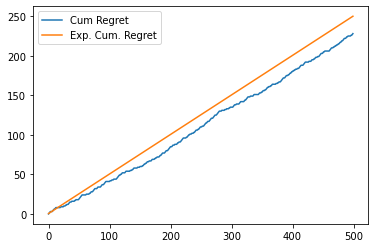

In [382]:
fig, ax = plt.subplots()
ax.plot(range(500), agent.cumulative_regret(), label='Cum Regret')
ax.plot(range(500), agent.expected_cumulative_regret(), label='Exp. Cum. Regret')
ax.legend()
plt.show()

6. Compare the regret for different exploration strategies. For $n=500$, compare the regret with $c=[1/128, 1/32, 1/8, 1/2, 1, 2, 8, 32, 1000]$ and the common choice
$c(n)=\sqrt{2\log{\sum_k n_k}}$ against each other. You can include the expected regret in your plot.

Run your code with different random seeds for the bandit, to see how much variability there is. Average the regret for each $c$ over 50 agents to reduce variance.

Is there a reason, if any, to prefer $c(n)$ over constant values of $c$? 

<ipython-input-383-87de4a3894db>:75: RuntimeWarning: divide by zero encountered in log
  exploration_factor = np.sqrt(2 * np.log(self.n_pulls))
<ipython-input-383-87de4a3894db>:75: RuntimeWarning: invalid value encountered in sqrt
  exploration_factor = np.sqrt(2 * np.log(self.n_pulls))


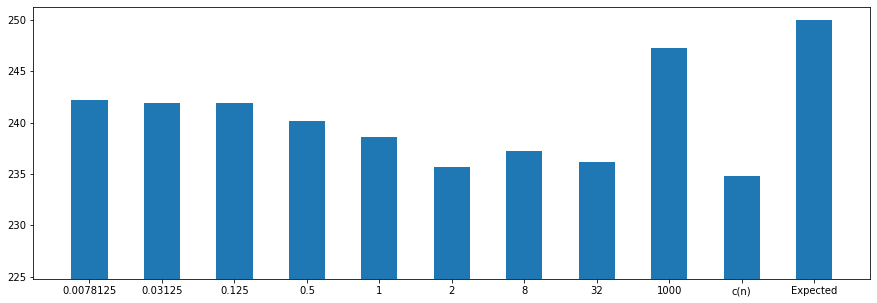

In [421]:
cs = [1/128,1/32,1/8,1/2,1,2,8,32,1000, None]
K=3
probabilities = [.45,.5,.55]
B = 50

regrets = np.zeros(len(cs)+1)

for i, c in enumerate(cs):
    var_regrets = np.zeros(B)
    var_exp_regrets = np.zeros(B)
    for j in range(B):
        bandit = MultiArmedBandit(K, probabilities=probabilities, seed=j*42)
        agent = Agent(bandit)
        agent.learn(500, c)
        var_regrets[j] = agent.regret()
    regrets[i] = var_regrets.mean()

regrets[-1] = agent.expected_regret()
fig, ax = plt.subplots(figsize=(15,5))
y_bottom = regrets.min()-10
ax.bar(np.arange(len(cs)+1), regrets-y_bottom, tick_label=cs[:-1] + ['c(n)', 'Expected'], width=.5, bottom=y_bottom)
plt.show()


7. When is a low regret rather not indicating that the agent has found the best solution?

In [10]:
# your optional code